# Statistical Power, Analysis of Variance, and Chi-Squared Goodness of Fit

## Objectives

- Recognize how power analysis sets up hypothesis tests
- Understand the issues of multiple comparisons
- Compare and contrast t-tests with ANOVA
- Implement ANOVA in Python
- Understand how the χ2-statistic and tests are similar to other hypothesis tests (t-test, ANOVA, etc.)
- Calculate the χ2-statistic
- Perform a χ2 goodness-of-fit test
- Perform a χ2 test for independence

In [1]:
# Overall Imports
import pandas as pd 
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Power Analysis

Running a power analysis allows you to estimate the minimum sample size required in order to find some minimum effect size, while setting your tolerance for both Type 1 and Type 2 Errors.

That's right - there's a relationship between your experiment's sample size, your significance level ($\alpha$), your statistical power ($1-\beta$), and the effect size you'd be able to measure with such a hypothesis test!

[Useful Resource: Machine Learning Mastery's Gentle Introduction to Statistical Power and Power Analysis in Python](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/)


Let's break down some of those pieces that we haven't discussed as much:

## Statistical Power

At its core, the statistical power of a test is simply $1 - \beta$, where $\beta$ is the chance of making a Type II Error.

<img src="images/confusionmatrix.png" alt="type 1 and type 2 errors in a confusion matrix chart" width=600>

Statistical power captures the likelihood that you'll find what you're looking for - so it makes sense that you'll only run a test if it's likely you'll find results. 


## Effect Size

Effect size is used to quantify the size of the difference between two groups under observation. Effect sizes are easy to calculate, understand and apply to any measured outcome and is applicable to a multitude of study domains. It is highly valuable towards quantifying the effectiveness of a particular intervention, relative to some comparison. Measuring effect size allows scientists to go beyond the obvious and simplistic, 'Does it work or not?' to the far more sophisticated, 'How well does it work in a range of contexts?'.

### Where does gender have a larger effect?

![gender effect size in seals vs pugs](images/gendereffectsize.png)

### Specifically, knowing the effect size helps you with:

- Communicate practical significance of results: an effect might be statistically significant, but does it matter in practical scenarios?

- Draw Meta-Analytical conclusions. This allows you to group together a number of existing studies, calculate the meta-analytic effect size and get the best estimate of the effect size of the population

- Perform a Power Analysis (aka why we're talking about this right now!), which help determine the number of participants (sample size) that a study would require to achieve a certain probability of finding a true effect - if there is one

### Cohen's $d$, standardized metric for effect size

Cohen’s $d$ is one of the most common ways to measure effect size. As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable.

$$ d = \frac{\text{effect size (difference of means)}}{\text{pooled standard deviation}} $$

Here's a formula to calculate it!

In [2]:
def Cohen_d(group1, group2):
    '''
    Compute Cohen's d

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float, for Cohen's d 
    '''

    diff = group1.mean() - group2.mean()

    n1 = len(group1)
    n2 = len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2 - 2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

#### Evaluating Effect Size

[good demo here](https://rpsychologist.com/d3/cohend/)

In general:

- Small effect = 0.2
- Medium Effect = 0.5
- Large Effect = 0.8

## Signifiance Level $\alpha$ (A Recap)

When conducting hypothesis testing, we __choose__ a value for alpha, which represents the margin of Type 1 Error we are allowing. Remember, alpha represents the probability in which we are allowed to take the risk of falsely rejecting the null hypothesis. By convention, we set the alpha at 0.05, which we can interpret as "5% of the time, we are willing to reject the null hypothesis when it is in fact true"

## Tie it all back together

How does sample size affect power?

In [3]:
# Well, let's find out!
from statsmodels.stats.power import TTestIndPower

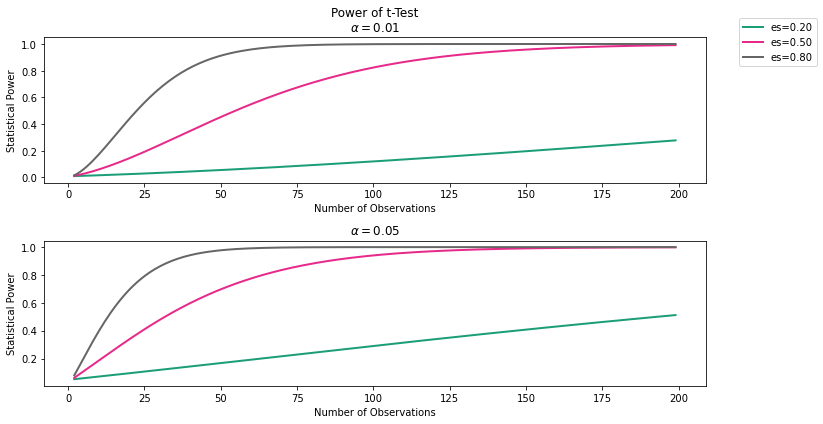

In [27]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.01,
                                 ax=ax, title='Power of t-Test' + '\n' + r'$\alpha = 0.01$')
ax.get_legend().remove()
plt.ylabel("Statistical Power")
ax = fig.add_subplot(2,1,2)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
plt.ylabel("Statistical Power")
plt.tight_layout()
plt.legend(loc=(1.05,2.2));

Elements that affect Statistical Power (chance of Type 2 Error):
- Effect Size
- Sample Size
- Alpha (chance of Type 1 Error)

## Quick Case Study 

Suppose you are launching a pilot study with Instagram and you want to examine the new feature (making the heart when you "like" someone's photo white instead of red) developed by the frontend engineer attracted more likes __given__ other variables are being held constant. You have collected two datasets. 

In [5]:
experiment = pd.read_csv('data/ig_experiment.csv', index_col=0)
control = pd.read_csv('data/ig_control.csv', index_col=0)

### Look at the data

In [6]:
experiment.head()

,ID_Exp,Likes_Given_Exp,Avg_Likes_Given_Exp
0,1,47,50
1,2,54,54
2,3,52,59
3,4,54,45
4,5,45,55


In [7]:
control.head()

,ID_Con,Likes_Given_Con,Avg_Likes_Given_Con
0,1,59,50
1,2,50,52
2,3,55,53
3,4,52,52
4,5,59,52


#### Solve for sample size

We can use `power_analysis.solve_power` from `statsmodels` to find the sample size you need.

[documentation here](https://www.statsmodels.org/dev/generated/statsmodels.stats.power.tt_ind_solve_power.html)

In [8]:
effect_size = Cohen_d(control['Likes_Given_Con'], experiment['Likes_Given_Exp'])
effect_size

0.9781835664336842

In [9]:
# before we even start the experiment, we want to know in order to attain a power of .8 
# given an alpha of .05, how many observations we need 
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower() # Instantiating!
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)
sample_size

17.420351015693946

In [32]:
power_analysis = TTestIndPower()
statistical_power = power_analysis.solve_power(
    effect_size=effect_size, 
    alpha=alpha, 
    nobs1=len(experiment)
)
statistical_power

0.9809432304805579

------

# More Statistical Tests

We've seen that hypothesis tests generally follow this pattern:

$$ \huge \frac{\text{Observed difference} - \text{Expectation if } H_0 \text{ is true}}{\text{Average Variance}}$$

Let's explore two more statistical tests that are used in other cases, going beyond z-tests and t-tests.

## ANOVA 

ANOVA, short for **An**alysis **o**f **Va**riance, is a commonly used statistical method for comparing means using the calculated F-statistic of 3 groups or more.  

<img src='images/rsz_anova-800x444.jpg'>


### T-Test or ANOVA?

Suppose we want to compare whether multiple groups differ in some type of measures. For example, we have collected mood data grouped by four types of weather - sunny, raining, overcast, or snowy, and we want to find out whether there is a difference in mood across different weather. What tests would you use?

A natural reaction would be to conduct multiple t-tests. However, that comes with many drawbacks. First, you would need $\frac{n(n-1)}{2}$ t tests, which come out to 6 tests. Having more tests meaning you create a higher chance of making type I errors. In this case, our original probability of making type I error grew from 5% to 5% x 6 = 30%! By conduct 6 tests and comparing their mean to each other, we are running a huge risk of believing in false positives. 

How then, can we combat this? **ANOVA**!

Instead of looking at each individual difference, ANOVA examines the ratio of variance between groups, and variance within groups, and find out whether the ratio is big enough to be statistically significant. 

### T-Test Statistics

## $$t = \frac{x\bar - \mu}{\frac{s}{\sqrt n}}$$

### ANOVA - the F test

## $$F = \frac{MS_{between}}{MS_{within}}$$

We can also say that a t-test is a special case of ANOVA, in that we are comparing the means of only two groups.

### What is the f-statistic? 

<img src='images/f-stat.png'>
    
The test statistic for ANOVA follows the F-distribution, a continuous probability function with 2 unique values, the degrees of freedom of groups and the degrees of freedom of all subjects. It is positively skewed and defined only for positive values. 

If, a = number of groups AND N = total number of subjects THEN 
    
- Degrees of freedom numerator = a - 1
- Degrees of freedom denominator = N - a

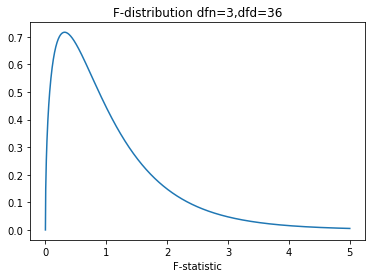

In [33]:
# here's one example
x = np.linspace(0,5,1000)
y = stats.f.pdf(x,3,36) # F distribution!
plt.plot(x,y)
plt.title('F-distribution dfn=3,dfd=36')
plt.xlabel('F-statistic');

Like all tests, we calculate a test statistic (here, F-ratio or F-statistic) that we can then translate into a p-value to compare with the critical value
    
If your data is array-like:

```python
stats.f_oneway(group1, group2, group3) # Note - can pass as many groups as you like!
```

(note that this is a one way ANOVA... which is the only version we're going to talk about!)

### Let's look at an example

A company is wondering how they can best optimize the performance of their data scientists. They devise an experiment to test the effect of various substances on the quality of work completed by their data scientists. They come up with four groups:

      Group A:  Given 150mg of caffeine
      Group B:  Given 2 ounces of alcohol
      Group C:  Given 100g of chocolate
      Group D:  Given 10 ounces of water
After ingesting their given substance, each data scientist was then given the same assessment. After two hours, the accuracy of each data scientist's model was evaluated and recorded and the results are shown below. With a confidence level of 95%, is there a difference in performance across the groups?

In [11]:
A = [0.92, 0.89, 0.94, 0.91, 0.79, 0.90, 0.96, 0.94, 0.92, 0.85]
B = [0.65, 0.79, 0.99, 0.48, 0.54, 0.68, 0.52, 0.49, 0.52, 0.56]
C = [0.85, 0.89, 0.91, 0.92, 0.86, 0.82, 0.94, 0.90, 0.91, 0.95]
D = [0.69, 0.75, 0.85, 0.74, 0.76, 0.85, 0.78, 0.72, 0.84, 0.86]

In [12]:
f_stat,p_value = stats.f_oneway(A,B,C,D)
print('F-stat:',f_stat)
print('p-value:',p_value)

F-stat: 19.986414188904373
p-value: 8.500667468792516e-08


### Another Example!

In [13]:
data = pd.read_csv('data/bikeshare_day.csv')
data.head()
# cnt is the outcome we are trying to predict

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [14]:
# mapping the season names onto the data
seasons = {1: 'spring',
           2: 'summer',
           3: 'fall',
           4: 'winter'}
data['season_cat'] = data.season.map(seasons)

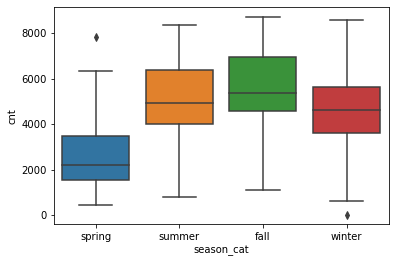

In [15]:
# boxplot
sns.boxplot(x='season_cat', y='cnt', data=data)
plt.show()

In [16]:
spring = data.loc[data['season'] == 1]['cnt']
summer = data.loc[data['season'] == 2]['cnt']
fall = data.loc[data['season'] == 3]['cnt']
winter = data.loc[data['season'] == 4]['cnt']

In [17]:
f_stat,p_value = stats.f_oneway(spring,summer,fall,winter)

In [18]:
print('F-stat:',f_stat)
print('p-value:',p_value)

F-stat: 128.76962156570784
p-value: 6.720391362913176e-67


## A New Class: Non-Parametric Tests

So far with $z$-tests, $t$-tests, and $F$-tests (ANOVA) we've been using the mean $\mu$ and standard deviation $\sigma$ to address a question. These are all *parametric tests* (use parameters to describe the null hypothesis).

But imagine if we had something like I asked 50 men and 50 women if they preferred pizza (🍕) or pasta (🍝)

|     |  🍕 | 🍝  |
| --- | --- | --- |
|  ♀  | 31  | 19  |
|  ♂  | 28  | 22  |

We really couldn't say something about the average favorite food. 

Instead, we tend to talk about proportions or frequencies to describe the data. This is where *non-parametric tests* can come in handy.

# The $\chi^2$ Test

When we talk about categorical variables vs other categorical variables (compared to continuous variables), the $\chi^2$ test is a good fit for our test.

There are a few different $\chi^2$ tests but they all center around the **$\chi^2$ statistic** and the [**$\chi^2$ distribution**](https://en.wikipedia.org/wiki/Chi-square_distribution).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Chi-square_distributionPDF.png/640px-Chi-square_distributionPDF.png)

The number of degrees of freedom for the $\chi^2$ distribution is $k$-1, where $k$ is the number of groups. For the $\chi^2$ distribution $k$ is also the *mean* of the distribution:

In [19]:
dist = stats.chi2(1)
dist.mean()

1.0

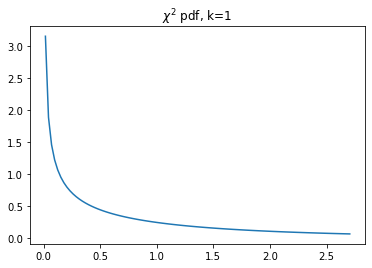

In [20]:
fig, ax = plt.subplots()

x = np.linspace(dist.ppf(0.1), dist.ppf(0.9), 100)
y = dist.pdf(x)

ax.plot(x, y)
ax.set_title('$\chi^2$ pdf, k=1');

Going back to our pizza vs pasta example, let's imagine we ask 100 individuals about their preference:


|                  |  🍕 | 🍝  |
| ---------------- | --- | --- |
| **OBSERVATIONS** | 52  | 48  |


It's not necessarily obvious if there is a _statistically_ significant difference in preference.

There are actually different $\chi^2$ hypothesis tests and they have different use cases but all surround observing different categories from different groups.

# $\chi^2$ Goodness-of-Fit Test

> If we are looking to see if some observed proportion _matches_ an expected proportion in relation to one variable, we do a **$\chi^2$ goodness-of-fit test**.

The steps follow like this:

1. Start with your _observation_ frequencies/proportions for each group
2. State what your _expectations_ were for each group
3. Check your assumptions (no expected frequency $\lt 5$)
4. Calculate the $\chi^2$ statistic
5. Determine your p-value via your $\chi^2$ statistic and degrees of freedom using the $\chi^2$ distribution
6. Interpret!

Let's try out an example as we work out how this test works.

## Observations

Suppose a company has hired us on. The company has been running a website in the U.S. but is now expanding it to other countries, namely the U.K. They would like to know if the U.K. users are "typical" in comparison to U.S. users.

They tell us that at the beginning of signing up with the site, the users can choose one of four types of profiles: **A**, **B**, **C**, & **D**.

There was an experiment run by the company where $400$ U.K. users were given early access to the platform. Their choice in profiles were the following:

|              |  A  |  B  |  C  |  D  |
| ------------ | --- | --- | --- | --- |
| **UK USERS** | 50  | 100 | 180 | 70  |

## Expected Values

Now to determine if these U.K users are similar to U.S. users, we need to know what profile types  the U.S. users choose.

Suppose we have historical data on U.S. users and know:

- **A** is chosen $15\%$ of the time
- **B** is chosen $20\%$ of the time
- **C** is chosen $45\%$ of the time
- **D** is chosen $20\%$ of the time

Then we would _expect_ that the $400$ U.K. users would follow the same pattern. Note this assumes the $H_0$ (there is no difference between U.K. & U.S. users). 

Thus we get the following expectations:

|              |  A  |  B  |  C  |  D  |
| ------------ | --- | --- | --- | --- |
| **EXPECTED** | 60  | 80  | 180 | 80  |

To make life easier for us, let's combine this into one table:

|              |  A  |  B  |  C  |  D  |
| ------------ | --- | --- | --- | --- |
| **UK USERS** | 50  | 100 | 180 | 70  |
| **EXPECTED** | 60  | 80  | 180 | 80  |

## No Expected Frequency $\lt 5$

Quickly, we should note that if any of the expected frequency is less than $5$ the $\chi^2$ test can have some issues.

Technically, this is arbitrary (like many of our limits in statistics) but is generally a good rule of thumb.

In this case, we see no expected frequency falls under $5$ so we're good to proceed! 👍🏼

## Calculate $\chi^2$ Statistic

Now we want to determine our test statistic. Recall what we want in a statistic:

$$ \large \frac{\text{Observed difference} - \text{Expectation if } H_0 \text{ is true}}{\text{Average Variance}}$$

Remember, we really want to capture the observed difference from what we'd expect. But if we did this and summed theses differences we'd always get $0$. So instead we square the differences before adding them.

We still need to scale these differences and we naturally use the expectation value for each group.

This gives us the $\chi^2$ statistic:


$$\large \chi^2 = \sum \frac{( Expected_i - Observed_i)^2}{Expected_i}$$

--------------

So back to our example, we'll use our table to organize the values:

|                     |  A  |  B  |  C  |  D  |
| :-----------------: | --- | --- | --- | --- |
| **UK USERS**        | 50  | 100 | 180 | 70  |
| **EXPECTED**        | 60  | 80  | 180 | 80  |
| $\frac{(E-O)^2}{E}$ | 1.67| 5.00| 0.00| 1.25|

This gives $\chi^2 \approx 1.67	+ 5.00 + 0.00 + 1.25 = 7.92$

## Determine p-value

Our last step is to determine the p-value via the $\chi^2$ distribution.

One consideration is the _degrees of freedom_ (think back to our $t$-distribution). But how do we calculate the degrees of freedom here?

Well, the **degrees of freedom** are really related to **how many categories/groups** we used (number of categories minus 1: $df = k-1$)

So in this case $df = 3$ and gives this distribution:

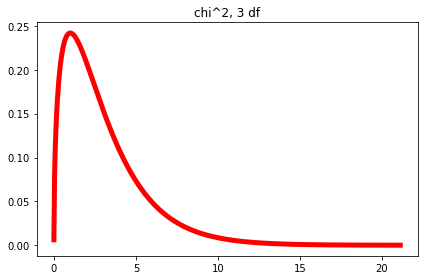

In [34]:
degrees_of_freedom = 3
x = np.linspace(
        stats.chi2.ppf(0.000001, degrees_of_freedom),
        stats.chi2.ppf(0.9999, degrees_of_freedom), 
        500
)

f, ax = plt.subplots()
ax.set_title('chi^2, 3 df')
ax.plot(x, stats.chi2.pdf(x, degrees_of_freedom), 'r-', lw=5)
plt.tight_layout()

> Notice we used [`scipy.stats.chi2`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html) to generate the PDF

Well, we also know our $\chi^2$ statistic is $7.92$ so let's plot that too so we can see how much area under the is more extreme than our statistic:

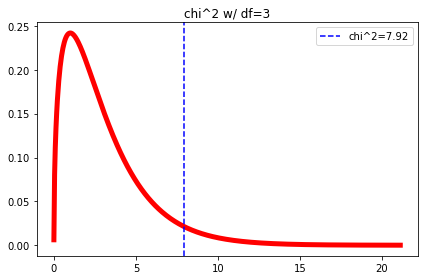

In [22]:
chisq_stat = 7.92

f, ax = plt.subplots()
ax.set_title('chi^2 w/ df=3')
ax.plot(x, stats.chi2.pdf(x, degrees_of_freedom), 'r-', lw=5)
# Chi-square statistic
ax.axvline(chisq_stat, ls='--', c='b', label='chi^2=7.92')
ax.legend()
plt.tight_layout()

This looks pretty small, but let's calculate the p-value to be sure. (Note we can use [`scipy.stats.chi2`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html) again to calculate the p-value of the distribution.)

In [23]:
# Note that we subtract since we want the area to the right of the statistic
p = 1 - stats.chi2.cdf(chisq_stat, df=degrees_of_freedom)
p

0.04769432461632517

In [24]:
stats.chi2.sf(chisq_stat, df=3)

0.04769432461632514

So not bad! For a significance level of $\alpha=0.05$, we would say this is significantly different!

So we can tell the company that, from the data provided, it appears that there is a statistically significant difference between U.S. and U.K. users.

## But I'm Lazy Like a Fox

As we saw before, if it's common enough someone probably already coded this up. Turns out there's a SciPy function [`scipy.stats.chisquare`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) that does this whole thing for us:

In [25]:
observations = [50, 100, 180, 70]
expectations = [60, 80, 180, 80]

result = stats.chisquare(f_obs=observations, f_exp=expectations)
result

Power_divergenceResult(statistic=7.916666666666667, pvalue=0.04776571858126222)

Sure enough, we get about the same values as we did by hand (but with a lot less work!)